2020.07.31 kouui

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("../../")

%load_ext autoreload
%autoreload 2

from src.Structure import AtomCls
from src.Atomic import Collision

from src.Util import Class

import Lib2

---

In [3]:
folder = "../../data/atom/Ca_II/"
file_Level     = folder + "Ca_II.Level"
file_Aji = folder + "Einstein_A/Nist.Aji"
file_CEe = folder + "Collisional_Excitation/RH.Electron"
atom = AtomCls.Atom(file_Level, _file_Aji=file_Aji, _file_CEe=file_CEe)

file_CIe = folder + "Collisional_Ionization/RH.Electron"
atom.read_CI(_path_electron=file_CIe)

file_PI  = folder + "Photoionization/RH.Alpha"
atom.read_PI(_path_alpha=file_PI)

file_Rad = folder + "Ca_II.RadiativeLine"
atom.read_RadiativeLine_and_make_Line_Mesh(_path=file_Rad)
atom.make_Cont_Mesh()
atom.read_RadLine_intensity(_folder="../../data/intensity/Ca_II/")

Reading Einstein Aji coefficient from : 
 ../../data/atom/Ca_II/Einstein_A/Nist.Aji
...
Finished.

Reading Electron impact Effective Collisional Strength from : 
 ../../data/atom/Ca_II/Collisional_Excitation/RH.Electron
Finished.

Reading Electron impact Collisional Ionization coefficient from : 
 ../../data/atom/Ca_II/Collisional_Ionization/RH.Electron
Finished.

Reading Photoionization cross section from : 
 ../../data/atom/Ca_II/Photoionization/RH.Alpha
Finished.

Reading Radiative Line information from : 
 ../../data/atom/Ca_II/Ca_II.RadiativeLine
line mesh prepared.
continuum mesh prepared.


In [4]:
Te = 8E3
Ne = 1E12
#Vt = 5E5
#Vd = 0E5

In [5]:
n_LTE, ni_LTE, nj_LTE = Lib2.ni_nj_LTE(atom,Te,Ne)

In [6]:
res = Lib2.bf_R_rate(atom, Te, ni_LTE, nj_LTE, _Tr=6000)
Rik, Rki_stim, Rki_spon = res

In [7]:
Bij_Jbar, Bji_Jbar = Lib2.B_Jbar(atom, _Tr=6000)

In [8]:
#CEij = Lib2.CEij_rate_coe(atom, Te)
#CIik = Lib2.CIik_rate_coe(atom, Te)
Cij = Lib2.get_Cij(atom, Te)
Cji = Collision.Cij_to_Cji(Cij, ni_LTE, nj_LTE)

## Plots

### Te, Ne v.s. collisional excitation

In [9]:
Te_arr = np.logspace(3.5, 5, 101,endpoint=True)
#Ne_arr = np.logspace(9, 14, 101, endpoint=True)
nTe = Te_arr.shape[0]
#nNe = Ne_arr.shape[0]

CEij_arr = np.zeros((atom.nLine, nTe))

for k in range(nTe):
    CEij_arr[:,k]= Lib2.CEij_rate_coe(atom, Te_arr[k])

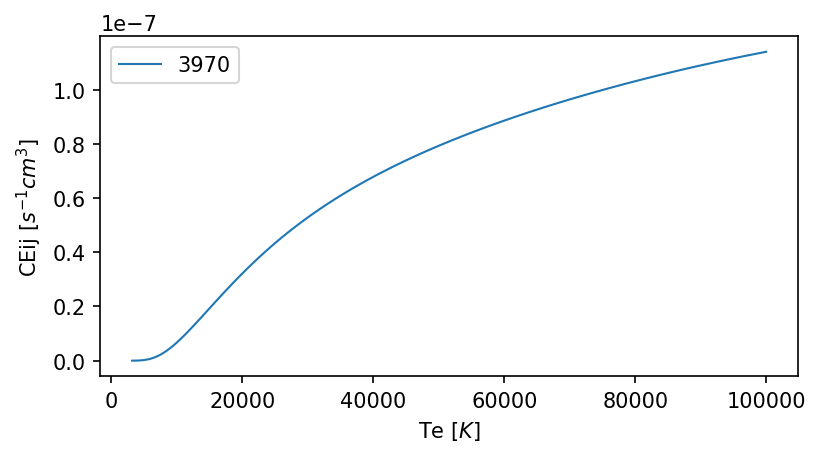

In [10]:
names = [f"{atom.Line.w0_AA[i]:.0f}" for i in atom.I_Rad.lineIndex]
index = [i for i in atom.I_Rad.lineIndex]

k = 0

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150)
ax.plot(Te_arr, CEij_arr[index[k],:], linewidth=1, label=names[k])

ax.set_xlabel("Te [$K$]")
ax.set_ylabel("CEij [$s^{-1}cm^{3}$]")
ax.legend(loc="best")
plt.show()

### photo-excitation v.s. collisional excitation

In [11]:
# electron temperature
Te_arr = np.logspace(3.5, 5, 101,endpoint=True)
nT = Te_arr.shape[0]
# radiation temperature
Tr_arr = np.logspace(3.5, 5, 101,endpoint=True)


Bij_Jbar_arr = np.zeros((atom.nLine, nT))
CEij_arr = np.zeros((atom.nLine, nT))

for k in range(nT):
    CEij_arr[:,k]= Lib2.CEij_rate_coe(atom, _Te=Te_arr[k])
    
    Bij_Jbar_arr[:,k], _Bji_Jbar = Lib2.B_Jbar(atom, _Tr=Tr_arr[k])

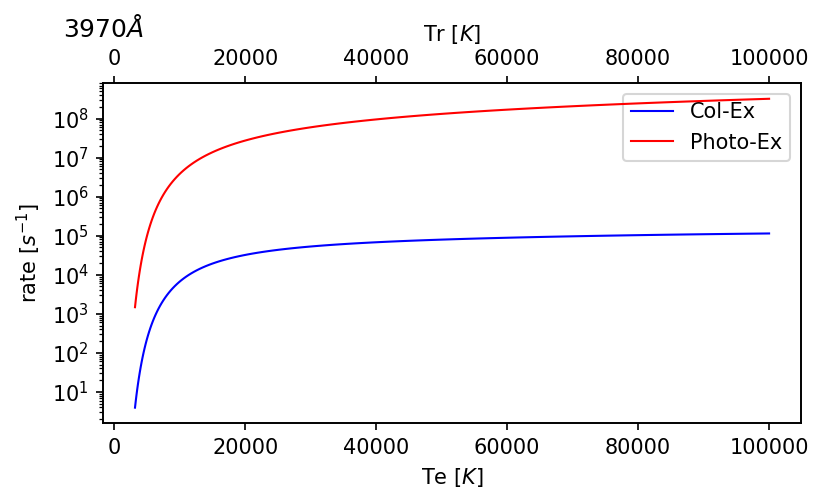

In [12]:
names = [f"{atom.Line.w0_AA[i]:.0f}" for i in atom.I_Rad.lineIndex]
index = [i for i in atom.I_Rad.lineIndex]

k = 0
Ne = 1E12

fig, ax = plt.subplots(1,1, figsize=(6,3), dpi=150)
lns1 = ax.plot(Te_arr, Ne*CEij_arr[index[k],:],"b", linewidth=1, label="Col-Ex")
ax2 = ax.twiny()

lns2 = ax2.plot(Tr_arr, Bij_Jbar_arr[index[k],:],"r", linewidth=1, label="Photo-Ex")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc="best")

ax2.set_title(names[k]+"$\AA$", x=0.0, y=1.1)
ax.set_xlabel("Te [$K$]")
ax2.set_xlabel("Tr [$K$]")
ax.set_ylabel("rate [$s^{-1}$]")
ax.set_yscale("log")
plt.show()